# ICU Sepsis Management Dataset – Exploration

## 🩺 Project Context

This notebook is part of a demonstrator project simulating the creation of a privacy-preserving research database for ICU clinical decision support. The dataset is derived from MIMIC-III and focuses on the management of sepsis patients—a critical condition in intensive care medicine.

The project aligns with the requirements of the Arc Hub initiative at the University of Galway, which aims to develop infrastructure for multimodal machine learning models using ICU data.

## 📦 Dataset Overview

This dataset includes:
- **Time-series physiological features:** Vitals, lab tests, and organ function indicators across time steps.
- **Interventions:** Actions such as administration of vasopressors, mechanical ventilation, etc.
- **Patient metadata:** Demographic and clinical information about each ICU stay.
- **Outcomes:** Patient mortality and other treatment-related results.

All data has been anonymized and is structured for offline reinforcement learning tasks. However, this project will focus on the **data engineering and preprocessing pipeline** to prepare the data for clinical research use.

## 🎯 Notebook Objectives

- Read and load all available data files.
- Explore the structure, size, and key features of each table.
- Begin identifying:
  - Patient-level identifiers
  - Time-series components
  - Outcome variables
  - Candidate features for linkage and anonymization

This will set the foundation for the next steps: data cleaning, anonymization, simulated linkage, and research database construction.

In [1]:
import pandas as pd
import os
import hashlib
import numpy as np
import random
import pymysql
from database_conn import create_database_if_not_exists, get_engine
from etl import run_etl
import logging
from sqlalchemy import text, create_engine
from data_cleaning import clean_and_store_tables
from patient_eda import preprocess_patients, preprocess_icustays
from auto_feature_engineering import auto_feature_engineering


## Read the CSV Source Files

In [2]:
data_path = './mimic-iii-clinical-database-demo-1.4/'

# Dictionary to store all DataFrames
dataframes = {}

# Read all CSV files in the folder
for file in os.listdir(data_path):
    if file.endswith('.csv'):
        file_path = os.path.join(data_path, file)
        df_name = file.replace('.csv', '')
        dataframes[df_name] = pd.read_csv(file_path)
        print(f"Loaded: {df_name} - Shape: {dataframes[df_name].shape}")

Loaded: ADMISSIONS - Shape: (129, 19)
Loaded: CALLOUT - Shape: (77, 24)
Loaded: CAREGIVERS - Shape: (7567, 4)


C:\Users\0132499s\AppData\Local\Temp\ipykernel_24324\1377128926.py:11: DtypeWarning: Columns (8,10,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes[df_name] = pd.read_csv(file_path)


Loaded: CHARTEVENTS - Shape: (758355, 15)
Loaded: CPTEVENTS - Shape: (1579, 12)
Loaded: DATETIMEEVENTS - Shape: (15551, 14)
Loaded: DIAGNOSES_ICD - Shape: (1761, 5)
Loaded: DRGCODES - Shape: (297, 8)
Loaded: D_CPT - Shape: (134, 9)
Loaded: D_ICD_DIAGNOSES - Shape: (14567, 4)
Loaded: D_ICD_PROCEDURES - Shape: (3882, 4)
Loaded: D_ITEMS - Shape: (12487, 10)
Loaded: D_LABITEMS - Shape: (753, 6)
Loaded: ICUSTAYS - Shape: (136, 12)
Loaded: INPUTEVENTS_CV - Shape: (34799, 22)
Loaded: INPUTEVENTS_MV - Shape: (13224, 31)
Loaded: LABEVENTS - Shape: (76074, 9)
Loaded: MICROBIOLOGYEVENTS - Shape: (2003, 16)
Loaded: NOTEEVENTS - Shape: (0, 11)
Loaded: OUTPUTEVENTS - Shape: (11320, 13)
Loaded: PATIENTS - Shape: (100, 8)
Loaded: PRESCRIPTIONS - Shape: (10398, 19)
Loaded: PROCEDUREEVENTS_MV - Shape: (753, 25)
Loaded: PROCEDURES_ICD - Shape: (506, 5)
Loaded: SERVICES - Shape: (163, 6)
Loaded: TRANSFERS - Shape: (524, 13)


C:\Users\0132499s\AppData\Local\Temp\ipykernel_24324\1377128926.py:11: DtypeWarning: Columns (17,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes[df_name] = pd.read_csv(file_path)


In [3]:
for name, df in dataframes.items():
    print(f"\n📁 {name} (rows: {df.shape[0]}, cols: {df.shape[1]})")
    display(df.head(3))


📁 ADMISSIONS (rows: 129, cols: 19)


,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1
1,12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,HEPATITIS B,1,1
2,12265,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,SEPSIS,1,1



📁 CALLOUT (rows: 77, cols: 24)


,row_id,subject_id,hadm_id,submit_wardid,submit_careunit,curr_wardid,curr_careunit,callout_wardid,callout_service,request_tele,...,callout_status,callout_outcome,discharge_wardid,acknowledge_status,createtime,updatetime,acknowledgetime,outcometime,firstreservationtime,currentreservationtime
0,3917,10017,199207,7,NaN,45,CCU,1,MED,1,...,Inactive,Discharged,45.0,Acknowledged,2149-05-31 10:44:34,2149-05-31 10:44:34,2149-05-31 15:08:04,2149-05-31 22:40:02,NaN,NaN
1,3919,10026,103770,33,NaN,3,SICU,3,NMED,1,...,Inactive,Discharged,3.0,Revised,2195-05-18 13:56:20,2195-05-19 15:45:30,NaN,2195-05-19 17:40:03,NaN,NaN
2,3920,10027,199395,12,NaN,55,CSRU,55,CSURG,1,...,Inactive,Discharged,55.0,Acknowledged,2190-07-20 08:15:20,2190-07-20 08:15:20,2190-07-20 08:57:46,2190-07-20 17:10:02,NaN,NaN



📁 CAREGIVERS (rows: 7567, cols: 4)


,row_id,cgid,label,description
0,2228,16174,RO,Read Only
1,2229,16175,RO,Read Only
2,2230,16176,Res,Resident/Fellow/PA/NP



📁 CHARTEVENTS (rows: 758355, cols: 15)


,row_id,subject_id,hadm_id,icustay_id,itemid,charttime,storetime,cgid,value,valuenum,valueuom,warning,error,resultstatus,stopped
0,5279021,40124,126179,279554.0,223761,2130-02-04 04:00:00,2130-02-04 04:35:00,19085,95.9,95.9,?F,0.0,0.0,NaN,NaN
1,5279022,40124,126179,279554.0,224695,2130-02-04 04:25:00,2130-02-04 05:55:00,18999,2222221.7,2222221.7,cmH2O,0.0,0.0,NaN,NaN
2,5279023,40124,126179,279554.0,220210,2130-02-04 04:30:00,2130-02-04 04:43:00,21452,15.0,15.0,insp/min,0.0,0.0,NaN,NaN



📁 CPTEVENTS (rows: 1579, cols: 12)


,row_id,subject_id,hadm_id,costcenter,chartdate,cpt_cd,cpt_number,cpt_suffix,ticket_id_seq,sectionheader,subsectionheader,description
0,4615,10117,105150,ICU,NaN,99254,99254,NaN,1.0,Evaluation and management,Consultations,NaN
1,4616,10117,105150,ICU,NaN,99231,99231,NaN,2.0,Evaluation and management,Hospital inpatient services,NaN
2,4617,10117,105150,ICU,NaN,90935,90935,NaN,3.0,Medicine,Dialysis,NaN



📁 DATETIMEEVENTS (rows: 15551, cols: 14)


,row_id,subject_id,hadm_id,icustay_id,itemid,charttime,storetime,cgid,value,valueuom,warning,error,resultstatus,stopped
0,208474,10076,198503,201006.0,5684,2107-03-25 04:00:00,2107-03-25 04:34:00,20482,2107-03-24 00:00:00,Date,NaN,NaN,NaN,NotStopd
1,208475,10076,198503,201006.0,5684,2107-03-25 07:00:00,2107-03-25 07:06:00,15004,2107-03-24 00:00:00,Date,NaN,NaN,NaN,NotStopd
2,208836,10076,198503,201006.0,5684,2107-03-26 04:00:00,2107-03-26 05:31:00,20834,2107-03-24 00:00:00,Date,NaN,NaN,NaN,NotStopd



📁 DIAGNOSES_ICD (rows: 1761, cols: 5)


,row_id,subject_id,hadm_id,seq_num,icd9_code
0,112344,10006,142345,1,99591
1,112345,10006,142345,2,99662
2,112346,10006,142345,3,5672



📁 DRGCODES (rows: 297, cols: 8)


,row_id,subject_id,hadm_id,drg_type,drg_code,description,drg_severity,drg_mortality
0,1338,10130,156668,HCFA,148,MAJOR SMALL & LARGE BOWEL PROCEDURES WITH COMP...,NaN,NaN
1,2188,10114,167957,HCFA,518,PERCUTANEOUS CARDIOVASCULAR PROCEDURES WITHOUT...,NaN,NaN
2,2599,10117,187023,HCFA,185,DENTAL & ORAL DIS EXCEPT EXTRACTIONS & RESTORA...,NaN,NaN



📁 D_CPT (rows: 134, cols: 9)


,row_id,category,sectionrange,sectionheader,subsectionrange,subsectionheader,codesuffix,mincodeinsubsection,maxcodeinsubsection
0,1,1,99201-99499,Evaluation and management,99201-99216,Office/other outpatient services,NaN,99201,99216
1,2,1,99201-99499,Evaluation and management,99217-99220,Hospital observation services,NaN,99217,99220
2,3,1,99201-99499,Evaluation and management,99221-99239,Hospital inpatient services,NaN,99221,99239



📁 D_ICD_DIAGNOSES (rows: 14567, cols: 4)


,row_id,icd9_code,short_title,long_title
0,1,01716,Erythem nod tb-oth test,Erythema nodosum with hypersensitivity reactio...
1,2,01720,TB periph lymph-unspec,"Tuberculosis of peripheral lymph nodes, unspec..."
2,3,01721,TB periph lymph-no exam,"Tuberculosis of peripheral lymph nodes, bacter..."



📁 D_ICD_PROCEDURES (rows: 3882, cols: 4)


,row_id,icd9_code,short_title,long_title
0,1,1423,Chorioret les xenon coag,Destruction of chorioretinal lesion by xenon a...
1,2,1424,Chorioret les laser coag,Destruction of chorioretinal lesion by laser p...
2,3,1425,Chorioret les p/coag NOS,Destruction of chorioretinal lesion by photoco...



📁 D_ITEMS (rows: 12487, cols: 10)


,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid
0,1,1435,Sustained Nystamus,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1,2,1436,Tactile Disturbances,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
2,3,1437,Tremor,NaN,carevue,chartevents,NaN,NaN,NaN,NaN



📁 D_LABITEMS (rows: 753, cols: 6)


,row_id,itemid,label,fluid,category,loinc_code
0,1,50800,SPECIMEN TYPE,BLOOD,BLOOD GAS,NaN
1,2,50801,Alveolar-arterial Gradient,Blood,Blood Gas,19991-9
2,3,50802,Base Excess,Blood,Blood Gas,11555-0



📁 ICUSTAYS (rows: 136, cols: 12)


,row_id,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los
0,12742,10006,142345,206504,carevue,MICU,MICU,52,52,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325
1,12747,10011,105331,232110,carevue,MICU,MICU,15,15,2126-08-14 22:34:00,2126-08-28 18:59:00,13.8507
2,12749,10013,165520,264446,carevue,MICU,MICU,15,15,2125-10-04 23:38:00,2125-10-07 15:13:52,2.6499



📁 INPUTEVENTS_CV (rows: 34799, cols: 22)


,row_id,subject_id,hadm_id,icustay_id,charttime,itemid,amount,amountuom,rate,rateuom,...,orderid,linkorderid,stopped,newbottle,originalamount,originalamountuom,originalroute,originalrate,originalrateuom,originalsite
0,1184,10114,167957,234989,2171-11-03 15:00:00,30056,400.0,ml,NaN,NaN,...,2557279,2557279,NaN,NaN,NaN,ml,Oral,NaN,NaN,NaN
1,1185,10114,167957,234989,2171-11-03 20:00:00,30056,120.0,ml,NaN,NaN,...,7828849,2557279,NaN,NaN,NaN,ml,Oral,NaN,NaN,NaN
2,1186,10114,167957,234989,2171-11-03 23:00:00,30056,120.0,ml,NaN,NaN,...,2744159,2557279,NaN,NaN,NaN,ml,Oral,NaN,NaN,NaN



📁 INPUTEVENTS_MV (rows: 13224, cols: 31)


,row_id,subject_id,hadm_id,icustay_id,starttime,endtime,itemid,amount,amountuom,rate,...,totalamountuom,isopenbag,continueinnextdept,cancelreason,statusdescription,comments_editedby,comments_canceledby,comments_date,originalamount,originalrate
0,118897,42367,139932,250305,2147-10-29 16:45:00,2147-10-29 16:46:00,225799,60.000000,ml,NaN,...,ml,0,0,0,FinishedRunning,NaN,NaN,NaN,60.0,60.0
1,118898,42367,139932,250305,2147-10-20 13:17:00,2147-10-20 13:18:00,223258,10.000000,units,NaN,...,NaN,0,0,1,Rewritten,NaN,RN,2147-10-20 13:18:00,10.0,10.0
2,118899,42367,139932,250305,2147-10-29 03:23:00,2147-10-29 03:53:00,226089,99.999999,ml,199.999998,...,ml,0,0,0,FinishedRunning,NaN,NaN,NaN,100.0,200.0



📁 LABEVENTS (rows: 76074, cols: 9)


,row_id,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,flag
0,6244563,10006,NaN,50868,2164-09-24 20:21:00,19,19.0,mEq/L,NaN
1,6244564,10006,NaN,50882,2164-09-24 20:21:00,27,27.0,mEq/L,NaN
2,6244565,10006,NaN,50893,2164-09-24 20:21:00,10.0,10.0,mg/dL,NaN



📁 MICROBIOLOGYEVENTS (rows: 2003, cols: 16)


,row_id,subject_id,hadm_id,chartdate,charttime,spec_itemid,spec_type_desc,org_itemid,org_name,isolate_num,ab_itemid,ab_name,dilution_text,dilution_comparison,dilution_value,interpretation
0,134694,10006,142345,2164-10-23 00:00:00,2164-10-23 15:30:00,70012,BLOOD CULTURE,80155.0,"STAPHYLOCOCCUS, COAGULASE NEGATIVE",2.0,NaN,NaN,NaN,NaN,NaN,NaN
1,134695,10006,142345,2164-10-23 00:00:00,2164-10-23 15:30:00,70012,BLOOD CULTURE,80155.0,"STAPHYLOCOCCUS, COAGULASE NEGATIVE",1.0,90015.0,VANCOMYCIN,2,=,2.0,S
2,134696,10006,142345,2164-10-23 00:00:00,2164-10-23 15:30:00,70012,BLOOD CULTURE,80155.0,"STAPHYLOCOCCUS, COAGULASE NEGATIVE",1.0,90012.0,GENTAMICIN,<=0.5,<=,1.0,S



📁 NOTEEVENTS (rows: 0, cols: 11)


,row_id,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,text



📁 OUTPUTEVENTS (rows: 11320, cols: 13)


,row_id,subject_id,hadm_id,icustay_id,charttime,itemid,value,valueuom,storetime,cgid,stopped,newbottle,iserror
0,6540,10114,167957,234989.0,2171-10-30 20:00:00,40055,39.0,ml,2171-10-30 20:38:00,15029,NaN,NaN,NaN
1,6541,10114,167957,234989.0,2171-10-30 21:00:00,40055,35.0,ml,2171-10-30 21:18:00,15029,NaN,NaN,NaN
2,6542,10114,167957,234989.0,2171-10-30 23:00:00,40055,100.0,ml,2171-10-30 23:31:00,15029,NaN,NaN,NaN



📁 PATIENTS (rows: 100, cols: 8)


,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,9467,10006,F,2094-03-05 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1
1,9472,10011,F,2090-06-05 00:00:00,2126-08-28 00:00:00,2126-08-28 00:00:00,NaN,1
2,9474,10013,F,2038-09-03 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,1



📁 PRESCRIPTIONS (rows: 10398, cols: 19)


,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,drug_name_generic,formulary_drug_cd,gsn,ndc,prod_strength,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,route
0,32600,42458,159647,NaN,2146-07-21 00:00:00,2146-07-22 00:00:00,MAIN,Pneumococcal Vac Polyvalent,Pneumococcal Vac Polyvalent,PNEUMOcoccal Vac Polyvalent,PNEU25I,48548.0,6494300.0,25mcg/0.5mL Vial,0.5,mL,1,VIAL,IM
1,32601,42458,159647,NaN,2146-07-21 00:00:00,2146-07-22 00:00:00,MAIN,Bisacodyl,Bisacodyl,Bisacodyl,BISA5,2947.0,536338101.0,5 mg Tab,10,mg,2,TAB,PO
2,32602,42458,159647,NaN,2146-07-21 00:00:00,2146-07-22 00:00:00,MAIN,Bisacodyl,Bisacodyl,Bisacodyl (Rectal),BISA10R,2944.0,574705050.0,10mg Suppository,10,mg,1,SUPP,PR



📁 PROCEDUREEVENTS_MV (rows: 753, cols: 25)


,row_id,subject_id,hadm_id,icustay_id,starttime,endtime,itemid,value,valueuom,location,...,ordercategoryname,secondaryordercategoryname,ordercategorydescription,isopenbag,continueinnextdept,cancelreason,statusdescription,comments_editedby,comments_canceledby,comments_date
0,8641,42367,139932,250305,2147-10-03 16:40:00,2147-10-06 20:00:00,224263,4520,min,Right Femoral.,...,Invasive Lines,NaN,Task,1,0,0,FinishedRunning,NaN,NaN,NaN
1,8642,42367,139932,250305,2147-10-03 16:41:00,2147-10-12 16:38:00,225204,12957,min,Right Antecube,...,Invasive Lines,NaN,Task,1,0,0,FinishedRunning,NaN,NaN,NaN
2,8643,42367,139932,250305,2147-10-03 17:10:00,2147-10-18 15:15:00,225792,21485,min,NaN,...,Ventilation,NaN,Task,1,0,0,FinishedRunning,NaN,NaN,NaN



📁 PROCEDURES_ICD (rows: 506, cols: 5)


,row_id,subject_id,hadm_id,seq_num,icd9_code
0,3994,10114,167957,1,3605
1,3995,10114,167957,2,3722
2,3996,10114,167957,3,8856



📁 SERVICES (rows: 163, cols: 6)


,row_id,subject_id,hadm_id,transfertime,prev_service,curr_service
0,14974,10006,142345,2164-10-23 21:10:15,NaN,MED
1,14979,10011,105331,2126-08-14 22:34:00,NaN,MED
2,14981,10013,165520,2125-10-04 23:38:00,NaN,MED



📁 TRANSFERS (rows: 524, cols: 13)


,row_id,subject_id,hadm_id,icustay_id,dbsource,eventtype,prev_careunit,curr_careunit,prev_wardid,curr_wardid,intime,outtime,los
0,54440,10006,142345,206504.0,carevue,admit,NaN,MICU,NaN,52.0,2164-10-23 21:10:15,2164-10-25 12:21:07,39.18
1,54441,10006,142345,NaN,carevue,transfer,MICU,NaN,52.0,45.0,2164-10-25 12:21:07,2164-11-01 17:14:27,172.89
2,54442,10006,142345,NaN,carevue,discharge,NaN,NaN,45.0,NaN,2164-11-01 17:14:27,NaN,NaN


## The table based on role can be classified into different categories.

| Category             | Tables                                                                                                     | Description                                            |
| -------------------- | ---------------------------------------------------------------------------------------------------------- | ------------------------------------------------------ |
| 🧍 Patient Info      | `PATIENTS`, `ADMISSIONS`, `ICUSTAYS`, `TRANSFERS`                                                          | Static or episodic patient information and encounters. |
| 🧪 Measurements      | `CHARTEVENTS`, `LABEVENTS`, `DATETIMEEVENTS`, `MICROBIOLOGYEVENTS`                                         | Time-stamped physiological and lab data.               |
| 💊 Interventions     | `INPUTEVENTS_CV`, `INPUTEVENTS_MV`, `OUTPUTEVENTS`, `PROCEDUREEVENTS_MV`, `PRESCRIPTIONS`                  | Treatments, inputs, outputs, and administered drugs.   |
| 🧾 Diagnoses & Codes | `DIAGNOSES_ICD`, `PROCEDURES_ICD`, `DRGCODES`, `D_ICD_DIAGNOSES`, `D_ICD_PROCEDURES`, `D_CPT`, `CPTEVENTS` | Billing, diagnoses, and procedural codes.              |
| 🏷 Metadata          | `D_ITEMS`, `D_LABITEMS`, `CAREgivers`, `SERVICES`, `CALLOUT`                                               | Reference or descriptive tables.                       |
| 📓 Notes             | `NOTEEVENTS`                                                                                               | Clinical free-text notes. (Empty in your case)         |


In [4]:
ADMISSIONS = dataframes['ADMISSIONS']
CALLOUT = dataframes['CALLOUT']
CAREGIVERS = dataframes['CAREGIVERS']
CHARTEVENTS = dataframes['CHARTEVENTS']
CPTEVENTS = dataframes['CPTEVENTS']
DATETIMEEVENTS = dataframes['DATETIMEEVENTS']
DIAGNOSES_ICD = dataframes['DIAGNOSES_ICD']
DRGCODES = dataframes['DRGCODES']
D_CPT = dataframes['D_CPT']
D_ICD_DIAGNOSES = dataframes['D_ICD_DIAGNOSES']
D_ICD_PROCEDURES = dataframes['D_ICD_PROCEDURES']
D_ITEMS = dataframes['D_ITEMS']
D_LABITEMS = dataframes['D_LABITEMS']
ICUSTAYS = dataframes['ICUSTAYS']
INPUTEVENTS_CV = dataframes['INPUTEVENTS_CV']
INPUTEVENTS_MV = dataframes['INPUTEVENTS_MV']
LABEVENTS = dataframes['LABEVENTS']
MICROBIOLOGYEVENTS = dataframes['MICROBIOLOGYEVENTS']
NOTEEVENTS = dataframes['NOTEEVENTS']
OUTPUTEVENTS = dataframes['OUTPUTEVENTS']
PATIENTS = dataframes['PATIENTS']
PRESCRIPTIONS = dataframes['PRESCRIPTIONS']
PROCEDUREEVENTS_MV = dataframes['PROCEDUREEVENTS_MV']
PROCEDURES_ICD = dataframes['PROCEDURES_ICD']
SERVICES = dataframes['SERVICES']
TRANSFERS = dataframes['TRANSFERS']


### 🔑 Exploring Key Identifiers and Time Columns Across All Tables

This code iterates through all loaded dataframes to identify the presence of key identifiers (`subject_id`, `hadm_id`, `icustay_id`) and common time-related columns (e.g., `charttime`, `admittime`). For each table, it reports:

- Which key identifiers are present and how many unique values they contain.
- Which time columns are present and the range of datetime values in those columns.

To ensure robust handling of mixed data types in time columns, the code converts each time column to pandas datetime format using `pd.to_datetime` with `errors='coerce'`. This safely converts invalid or missing dates to `NaT`, allowing calculation of minimum and maximum dates without errors.

This exploration helps us understand data linkage keys and time ranges in each table, which is essential for data integration, cleaning, and anonymization.

In [5]:
key_ids = ['subject_id', 'hadm_id', 'icustay_id']
time_cols = ['charttime', 'starttime', 'endtime', 'admittime', 'dischtime', 'intime', 'outtime']

for name, df in dataframes.items():
    keys_found = [k for k in key_ids if k in df.columns]
    times_found = [t for t in time_cols if t in df.columns]
    print(f"\nTable: {name}")
    print(f" - Key IDs found: {keys_found}")
    print(f" - Time columns found: {times_found}")
    for key in keys_found:
        print(f"   Unique {key}s: {df[key].nunique()}")
    for t in times_found:
        # Convert to datetime, coerce errors to NaT
        col_as_datetime = pd.to_datetime(df[t], errors='coerce')
        print(f"   {t} range: {col_as_datetime.min()} to {col_as_datetime.max()}")


Table: ADMISSIONS
 - Key IDs found: ['subject_id', 'hadm_id']
 - Time columns found: ['admittime', 'dischtime']
   Unique subject_ids: 100
   Unique hadm_ids: 129
   admittime range: 2102-08-29 07:15:00 to 2202-10-03 01:45:00
   dischtime range: 2102-09-06 16:20:00 to 2202-10-11 16:30:00

Table: CALLOUT
 - Key IDs found: ['subject_id', 'hadm_id']
 - Time columns found: []
   Unique subject_ids: 51
   Unique hadm_ids: 67

Table: CAREGIVERS
 - Key IDs found: []
 - Time columns found: []

Table: CHARTEVENTS
 - Key IDs found: ['subject_id', 'hadm_id', 'icustay_id']
 - Time columns found: ['charttime']
   Unique subject_ids: 99
   Unique hadm_ids: 126
   Unique icustay_ids: 133
   charttime range: 2102-08-31 17:00:00 to 2202-05-02 22:27:00

Table: CPTEVENTS
 - Key IDs found: ['subject_id', 'hadm_id']
 - Time columns found: []
   Unique subject_ids: 91
   Unique hadm_ids: 118

Table: DATETIMEEVENTS
 - Key IDs found: ['subject_id', 'hadm_id', 'icustay_id']
 - Time columns found: ['charttime'

### 🔗 Core Data Linkage: Building a Unified Patient-Admission-ICU Dataset

To analyze clinical data effectively, we first establish a core linkage of patient information across multiple tables representing different levels of clinical care:

- **PATIENTS:** Contains demographic data for each patient (`subject_id`).
- **ADMISSIONS:** Contains hospital admission episodes (`hadm_id`) linked to patients.
- **ICUSTAYS:** Contains ICU stay episodes (`icustay_id`) linked to admissions.

Merging these tables on their respective keys (`subject_id` and `hadm_id`) creates a unified master dataset that forms the foundation for integrating detailed event data.

---

### ⚕️ Regarding HIPE Linkage

The HIPE dataset is an external hospital administrative database containing in-patient details, discharge summaries, and outcome data. Linking HIPE data with our ICU dataset enhances the clinical context by incorporating administrative and outcome information.

- This linkage typically requires access to the HIPE dataset separately.
- It involves matching patients and admissions based on identifiers and admission/discharge dates.
- Our current ICU datasets provide detailed clinical data, but external datasets like HIPE would be needed for enriched hospital administrative information.
- Once access to HIPE data is available, similar linkage principles will apply, maintaining data privacy and governance.

---

Next, we implement the core data linkage by merging `PATIENTS`, `ADMISSIONS`, and `ICUSTAYS` dataframes.


In [6]:
# Merge PATIENTS and ADMISSIONS on subject_id
patients_adm = pd.merge(
    PATIENTS,
    ADMISSIONS,
    on='subject_id',
    how='inner',
    suffixes=('_patient', '_adm')
)

# Merge the above with ICUSTAYS on subject_id and hadm_id
master_df = pd.merge(
    patients_adm,
    ICUSTAYS,
    on=['subject_id', 'hadm_id'],
    how='inner',
    suffixes=('', '_icu')
)

print(f"Master dataframe shape: {master_df.shape}")
print("Columns in master dataframe:", master_df.columns.tolist())
master_df.head(2)

Master dataframe shape: (136, 36)
Columns in master dataframe: ['row_id_patient', 'subject_id', 'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag', 'row_id_adm', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag', 'has_chartevents_data', 'row_id', 'icustay_id', 'dbsource', 'first_careunit', 'last_careunit', 'first_wardid', 'last_wardid', 'intime', 'outtime', 'los']


,row_id_patient,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id_adm,hadm_id,...,row_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los
0,9467,10006,F,2094-03-05 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1,12258,142345,...,12742,206504,carevue,MICU,MICU,52,52,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325
1,9472,10011,F,2090-06-05 00:00:00,2126-08-28 00:00:00,2126-08-28 00:00:00,NaN,1,12263,105331,...,12747,232110,carevue,MICU,MICU,15,15,2126-08-14 22:34:00,2126-08-28 18:59:00,13.8507


### 🔒 Data Anonymization Module

To protect patient privacy and comply with data protection regulations such as GDPR and HIPAA, it is essential to anonymize sensitive information before further analysis or sharing.

#### Anonymization Techniques Applied:

1. **Hashing Identifiers:**
   - The `subject_id`, `hadm_id`, and `icustay_id` columns are hashed using SHA-256 to create pseudonymous identifiers that cannot be reversed.
   - This maintains the ability to link records across tables while protecting the original IDs.

2. **Date Shifting:**
   - All datetime columns (`admittime`, `dischtime`, `intime`, `outtime`, etc.) are shifted by a consistent random offset per dataset run.
   - This preserves the relative timing and order of events but masks the actual calendar dates.

3. **Removing Original IDs:**
   - After hashing, the original identifier columns are dropped to prevent accidental exposure.

4. **Handling Demographics:**
   - For example, the exact date of birth or age can be binned or replaced with synthetic ranges or masked entirely (optional; not shown here but recommended).

### Benefits:
- Preserves data utility for analysis and modeling.
- Protects patient confidentiality.
- Enables safe data linkage with external datasets through hashed IDs.

In [7]:
# Function to hash IDs using SHA-256
def hash_id(x):
    if pd.isna(x):
        return np.nan
    return hashlib.sha256(str(x).encode()).hexdigest()

# List of identifier columns to hash
id_columns = ['subject_id', 'hadm_id', 'icustay_id']

# Apply hashing to create anonymized IDs
for col in id_columns:
    if col in master_df.columns:
        master_df[f'{col}_hashed'] = master_df[col].apply(hash_id)

# Define the datetime columns to shift
date_columns = ['admittime', 'dischtime', 'intime', 'outtime']

# Function to shift datetime columns by a random offset
def shift_dates(df, date_cols, seed=42):
    np.random.seed(seed)
    offset_days = np.random.randint(-365, 365)  # Shift dates by up to ±1 year
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce') + pd.Timedelta(days=offset_days)
    print(f"Dates shifted by {offset_days} days.")
    return df

# Shift dates in the master dataframe
master_df = shift_dates(master_df, date_columns)

# Drop original ID columns to protect privacy
master_df = master_df.drop(columns=[col for col in id_columns if col in master_df.columns])

# Optional: Inspect the anonymized dataframe
print(master_df[[f'{col}_hashed' for col in id_columns if f'{col}_hashed' in master_df.columns] + date_columns].head())

Dates shifted by -263 days.
                                   subject_id_hashed  \
0  a6c9b0f863d3c2056830114bb5edc235eb5257268e8c3e...   
1  ddf3ff7c110ced585a4061e3a3c66f7051fe6847fd4b56...   
2  5264efea3b4678d5937a9efb8fd5ec64e5761aec6efc64...   
3  7249e959389029a84a292d85358c7a030612196b5614a4...   
4  4ff717d584ed7ba18561048f91e809f437b03a42e6e253...   

                                      hadm_id_hashed  \
0  8a1c64b94b811e7567dbc2b827a912114af18b08370263...   
1  62a68f4f61e3f74574207213a7664b3350100a6205ebcb...   
2  fbb6b6b4f901db7272b3c5a93eaf468c1f238b7632fb22...   
3  2e644404e3ee2c4548947b8cf1967cb1ed9960608f5070...   
4  e1a5e79c2f00fd471379b8a603995025460585abec3b9e...   

                                   icustay_id_hashed           admittime  \
0  47b7ea9c34ba779420fcc22e90b39960f947e035d643fe... 2164-02-03 21:09:00   
1  43be48f2e31bf5c02ad89295063b7ea6ed7f58e1280570... 2125-11-24 22:32:00   
2  4f47394f60dc0f19daac27c76ebdfe5357af53ce537a84... 2125-01-14 23:36:

### 🌐 Simulating a HIPE-like Dataset for Data Linkage

To emulate the linkage process with an external HIPE dataset, we generate a synthetic HIPE-like dataset that contains:

- **Hashed patient identifiers** (`subject_id_hashed`, `hadm_id_hashed`) matching those in the anonymized ICU dataset.
- **Outcome variables** such as `readmission_flag` and `long_term_mortality` assigned randomly to simulate real clinical outcomes.
- **Unmatched records** with fabricated hashed IDs to represent patients present in HIPE but not in the ICU dataset, adding realism and testing linkage robustness.

#### Key Steps in the Simulation:

1. Extract unique hashed patient and admission IDs from the anonymized ICU master dataframe.
2. Randomly sample a majority of these IDs to represent patients who also appear in the HIPE dataset.
3. Create a small proportion of unmatched (fake) hashed IDs to mimic patients only present in HIPE.
4. Assign random binary outcomes (`0` or `1`) for readmission and mortality to all HIPE records.
5. Combine matched and unmatched records into a single synthetic HIPE dataframe ready for linkage.

This simulated dataset will serve as a proxy for real HIPE data and enable testing of the linkage and matching pipeline before accessing actual external datasets.

In [8]:
# Extract hashed IDs from master_df for simulation reference
hashed_ids = master_df[['subject_id_hashed', 'hadm_id_hashed']].drop_duplicates()

# Simulate HIPE dataset based on a subset of these IDs
# Add some random outcomes and possibly some unmatched IDs for realism
def generate_hipe_dataset(hashed_ids, size=None, mismatch_ratio=0.1):
    if size is None:
        size = len(hashed_ids)
    # Sample some records from hashed_ids to be in HIPE
    sample_ids = hashed_ids.sample(frac=1 - mismatch_ratio, random_state=42).reset_index(drop=True)

    # Add some unmatched records (not in ICU dataset)
    unmatched_size = int(size * mismatch_ratio)
    unmatched_subject_ids = [f"fake_subject_{i}" for i in range(unmatched_size)]
    unmatched_hadm_ids = [f"fake_hadm_{i}" for i in range(unmatched_size)]

    # Hash the fake IDs similarly
    unmatched_subject_ids_hashed = [hashlib.sha256(s.encode()).hexdigest() for s in unmatched_subject_ids]
    unmatched_hadm_ids_hashed = [hashlib.sha256(h.encode()).hexdigest() for h in unmatched_hadm_ids]

    unmatched_df = pd.DataFrame({
        'subject_id_hashed': unmatched_subject_ids_hashed,
        'hadm_id_hashed': unmatched_hadm_ids_hashed,
        'readmission_flag': [random.choice([0,1]) for _ in range(unmatched_size)],
        'long_term_mortality': [random.choice([0,1]) for _ in range(unmatched_size)]
    })

    # Generate outcome columns for matched sample
    sample_ids['readmission_flag'] = sample_ids['subject_id_hashed'].apply(lambda x: random.choice([0,1]))
    sample_ids['long_term_mortality'] = sample_ids['subject_id_hashed'].apply(lambda x: random.choice([0,1]))

    # Combine matched and unmatched to form full HIPE-like dataset
    hipe_df = pd.concat([sample_ids, unmatched_df], ignore_index=True)
    return hipe_df

# Create HIPE simulated dataset
hipe_simulated = generate_hipe_dataset(hashed_ids)

print(f"Simulated HIPE dataset shape: {hipe_simulated.shape}")
hipe_simulated.head()

Simulated HIPE dataset shape: (128, 4)


,subject_id_hashed,hadm_id_hashed,readmission_flag,long_term_mortality
0,3bd5092b9ea53e9b57ea1430889a69a854a954040d57e0...,be167afbc37b9820999771e7a593ba3217f5eb9d29d898...,0,0
1,3c2ffe67e845548bcfd646816a2b2fdcebdc3a095f6702...,826ef6c60d9e29be8b6fa8f4a607aceb501784db8ea748...,1,0
2,9d06e5d38103e667c2c57a5cf5cc3d4ecd1e74f0423e3d...,1d762af2ca95511866ca9167ca7e7a61eead8101eed6b0...,0,1
3,7be41cb37baa6cd725830ea77adfc19c525096c3b56e95...,7f979bd11b820668f4fffd4dc706db5f9c1beb5e64fca5...,1,1
4,127dca87ece98a690a637e98cc1507431d270ed919f2d9...,cf4d7a5bc944f0abf942553dbae69a9b35afbee86676b2...,0,0


### 🔗 Data Linkage with Simulated HIPE Dataset

To simulate real-world data integration, we perform a **record linkage** between our anonymized ICU dataset (`master_df`) and the synthetic HIPE dataset (`hipe_simulated`), using hashed identifiers.

#### 🔍 Join Strategy

We apply a **left join** on the following hashed identifiers:

- `subject_id_hashed`: Anonymized patient identifier
- `hadm_id_hashed`: Anonymized hospital admission identifier

This ensures that:
- All records from the ICU dataset (`master_df`) are retained.
- HIPE outcome data is appended where a match exists.
- Non-matching ICU records (i.e., patients not found in HIPE) will have `NaN` values in the new outcome columns.

In [9]:
# Linkage: Merge master_df with simulated HIPE on hashed IDs
linked_df = master_df.merge(
    hipe_simulated,
    on=['subject_id_hashed', 'hadm_id_hashed'],
    how='left',
    suffixes=('', '_hipe')
)

print(f"Linked dataframe shape: {linked_df.shape}")

Linked dataframe shape: (136, 38)


### 📊 Data Linkage Report: ICU Dataset ↔️ HIPE Simulation

After merging the anonymized ICU dataset (`master_df`) with the simulated HIPE dataset (`hipe_simulated`), we generated a linkage report to assess the success and integrity of the join process.

#### 🔍 Linkage Summary

| Metric                       | Value        |
|-----------------------------|--------------|
| **Total ICU records**       | 136          |
| **Records matched to HIPE** | 123          |
| **Records unmatched**       | 13           |
| **Match rate**              | 90.44%       |
| **Duplicate linked records**| 7            |

### ✅ Interpretation

- A **90.44% match rate** indicates high coverage between ICU and HIPE datasets.
- **13 unmatched records** suggest either missing entries in HIPE or unlinked patients.
- **7 duplicates** may represent repeated episodes or data quality issues, which can be further explored during the cleaning step.

This report validates the feasibility of a realistic data integration pipeline with partially overlapping patient records from different systems.

In [10]:
total_records = len(master_df)
matched_records = linked_df['readmission_flag'].notna().sum()
unmatched_records = total_records - matched_records
match_rate = matched_records / total_records * 100

print(f"Total ICU records: {total_records}")
print(f"Records matched to HIPE: {matched_records}")
print(f"Records unmatched: {unmatched_records}")
print(f"Match rate: {match_rate:.2f}%")

# Additional checks for duplicates or integrity
duplicates = linked_df.duplicated(subset=['subject_id_hashed', 'hadm_id_hashed']).sum()
print(f"Duplicate linked records: {duplicates}")

Total ICU records: 136
Records matched to HIPE: 123
Records unmatched: 13
Match rate: 90.44%
Duplicate linked records: 7


### 🗃️ Research Database Design & Storage

#### Step 1: Define Core Tables and Primary Keys

#### 🎯 Objective:
Design a clean relational schema using core entities derived from the linked dataset (`linked_df`), including patients, hospital admissions, ICU stays, and outcome labels.

---

#### 📦 Tables and Primary Keys:

| Table Name   | Description                                     | Primary Key           |
|--------------|------------------------------------------------|----------------------|
| `patients`   | Patient demographics and death information     | `subject_id_hashed`  |
| `admissions` | Hospital admission-level information            | `hadm_id_hashed`     |
| `icustays`   | ICU stay-level clinical information             | `icustay_id_hashed`  |
| `outcomes`   | Research outcomes (readmission & mortality)     | `icustay_id_hashed`  |


In [11]:
# Patients table
patients_table = linked_df[[
    'subject_id_hashed', 'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag'
]].drop_duplicates()

# Admissions table
admissions_table = linked_df[[
    'hadm_id_hashed', 'subject_id_hashed', 'admittime', 'dischtime', 'deathtime',
    'admission_type', 'admission_location', 'discharge_location',
    'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
    'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag'
]].drop_duplicates()

# ICU stays table
icustays_table = linked_df[[
    'icustay_id_hashed', 'hadm_id_hashed', 'subject_id_hashed',
    'intime', 'outtime', 'los', 'first_careunit', 'last_careunit',
    'first_wardid', 'last_wardid', 'has_chartevents_data'
]].drop_duplicates()

# Outcomes table
outcomes_table = linked_df[[
    'icustay_id_hashed', 'readmission_flag', 'long_term_mortality'
]].drop_duplicates()


#### Step 2: Export Tables from Pandas to CSV (for MySQL Import)

### 🎯 Objective:
Save the extracted core tables (`patients`, `admissions`, `icustays`, and `outcomes`) as `.csv` files to be imported into MySQL Workbench or any other database system.

---

In [12]:
patients_table.to_csv("../outputs/patients.csv", index=False)
admissions_table.to_csv("../outputs/admissions.csv", index=False)
icustays_table.to_csv("../outputs/icustays.csv", index=False)
outcomes_table.to_csv("../outputs/outcomes.csv", index=False)

### Step 3: Create SQL Database and Tables (from Python)

#### 🎯 Objective:
Instead of importing CSVs manually into MySQL Workbench, we'll **programmatically create a MySQL database schema and tables directly from Python** using `SQLAlchemy` and `pymysql`. This makes the linkage pipeline more seamless and reproducible.

---

In [13]:
create_database_if_not_exists(user='mimic_user',password='mypassword123')
engine = get_engine(user='mimic_user', password='mypassword123')

dataframes_to_insert = {
    'patients': patients_table,
    'admissions': admissions_table,
    'icustays': icustays_table,
    'outcomes': outcomes_table
}

tables = ['patients', 'admissions', 'icustays', 'outcomes']
run_etl(dataframes_to_insert, tables, user='mimic_user', password='mypassword123')

2025-07-30 21:48:08,867 - INFO - Inserting table patients with if_exists='replace'
2025-07-30 21:48:08,956 - INFO - Successfully inserted patients
2025-07-30 21:48:08,963 - INFO - Inserting table admissions with if_exists='replace'
2025-07-30 21:48:09,026 - INFO - Successfully inserted admissions
2025-07-30 21:48:09,030 - INFO - Inserting table icustays with if_exists='replace'
2025-07-30 21:48:09,082 - INFO - Successfully inserted icustays
2025-07-30 21:48:09,087 - INFO - Inserting table outcomes with if_exists='replace'
2025-07-30 21:48:09,160 - INFO - Successfully inserted outcomes


### 🛢️ Data Quality, Cleaning & Schema Design

#### Design Relational Schema (Logical ER Diagram)

We aim to build a research-ready relational schema that links patient demographic, admission, ICU stay, and outcome data.

#### Core Tables & Relationships

- **patients**: Contains patient demographics (e.g., subject_id, gender, dob)
- **admissions**: Hospital admission records linked by hadm_id
- **icustays**: ICU-specific stay details linked by icustay_id
- **outcomes**: Patient-level outcomes like readmission and mortality

#### Entity-Relationship Diagram

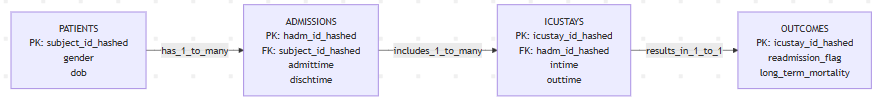

In this step, we aim to create a new table patient_outcomes that merges patient demographic data, hospital admission records, ICU stays, and outcome information into a single unified view.

<strong>Why do we join these tables?</strong>

- patients table contains patient demographic data, including a hashed subject_id_hashed that uniquely identifies each patient.
- admissions table contains details of hospital admissions, linked to patients by the same subject_id_hashed.
- icustays table contains ICU stay details, linked to hospital admissions by a hospital admission ID (e.g., hadm_id or its hashed version).
- outcomes table contains patient outcome flags (e.g., readmission, mortality) linked to ICU stays by icustay_id_hashed.

By joining these tables on their key columns, we create a comprehensive dataset that relates patient demographics, their admission details, ICU stay periods, and outcome data.

#### Notes:
- Each patient can have multiple admissions
- Each admission can have multiple ICU stays
- Outcomes are pre-computed and linked one-to-one with patients

---

In [14]:
engine = get_engine(user='mimic_user', password='mypassword123')
with engine.begin() as conn:
    conn.execute(text("""
    CREATE TABLE IF NOT EXISTS patient_outcomes AS
    SELECT
        p.subject_id_hashed,
        p.gender,
        p.dob,
        a.hadm_id_hashed,
        a.admittime,
        a.dischtime,
        i.icustay_id_hashed,
        i.intime AS icu_intime,
        i.outtime AS icu_outtime,
        o.readmission_flag,
        o.long_term_mortality
    FROM patients p
    LEFT JOIN admissions a ON p.subject_id_hashed = a.subject_id_hashed
    LEFT JOIN icustays i ON a.hadm_id_hashed = i.hadm_id_hashed
    LEFT JOIN outcomes o ON i.icustay_id_hashed = o.icustay_id_hashed;
    """))

### ✨ Data Quality and Cleaning Pipeline

In this step, we focus on ensuring the integrity, reliability, and usability of our dataset by performing thorough data cleaning and quality assurance processes. This includes handling missing data, detecting and managing outliers, validating timestamps, and documenting all transformations for reproducibility and auditability.

#### Handling Missing Data

- Analyze missingness per table and column.
- Decide on strategies to handle missing values:
  - Remove records or columns if missingness is excessive.
  - Impute missing values with domain-appropriate techniques (e.g., median, mean, forward-fill).
- Create flags indicating which values were imputed for transparency.

#### Outlier Detection and Management

- Identify outliers using statistical methods (e.g., Interquartile Range, z-scores).
- Assess if outliers represent true extremes or errors.
- Cap or replace outliers if necessary, documenting all actions.

#### Timestamp Validation and Correction

- Check logical consistency of timestamps (e.g., admission time must be before discharge time).
- Flag or correct invalid timestamp records.
- Record all changes for traceability.

#### Data Provenance and Logging

- Maintain a structured log of all data cleaning steps including:
  - Date and time of action
  - Affected table and columns
  - Description of the operation
  - Number of records affected
- This supports reproducibility, auditing, and compliance with data governance standards.

---

In [15]:
tables_to_clean = ['patients','admissions','icustays','outcomes','patient_outcomes']
clean_and_store_tables(tables_to_clean, engine)


🔄 Processing table: patients
✅ Cleaned table stored: patients_clean

🔄 Processing table: admissions
✅ Cleaned table stored: admissions_clean

🔄 Processing table: icustays
✅ Cleaned table stored: icustays_clean

🔄 Processing table: outcomes
✅ Cleaned table stored: outcomes_clean

🔄 Processing table: patient_outcomes
✅ Cleaned table stored: patient_outcomes_clean
📝 Provenance log saved as data_provenance_log.csv


### ⚙️ Patient, ICU Stay, and Diagnosis Data Preprocessing

#### Overview

This section is to preprocess key clinical tables: **patients**, **ICU stays**, and **diagnoses**. The goal is to extract and engineer meaningful patient-level summary features that can be used for further analysis, statistical exploration, or as input features for machine learning models.

#### Why do we preprocess?

Raw clinical data is often complex, sparse, and contains noisy or inconsistent information. Preprocessing helps by:

- **Cleaning and standardizing** key variables like dates and codes.
- **Aggregating data** to the patient-level to simplify analysis.
- **Generating interpretable features** such as age-at-death, ICU length of stay, or diagnosis counts.
- **Reducing data dimensionality** and preparing inputs that machine learning models can efficiently consume.
- **Capturing clinically relevant summaries** that reflect patient health status and history.

---
#### Function Descriptions and Goals

1. `preprocess_patients(df_patients)`

- **Purpose:** Process the patients table to extract age and mortality-related features.
- **Key steps:**
  - Convert birth and death date columns into datetime format.
  - Identify the patient's date and source of death from multiple possible fields.
  - Calculate the patient's age at death (if applicable).
  - Bucket ages into clinically meaningful groups (e.g., 0–18, 19–39, 40–64, 65+).
  - Create a binary flag indicating if the patient is deceased.
- **Goal:** Provide a clean, enriched patient demographic dataset that summarizes vital status and age information for each patient.

2. `preprocess_icustays(df_icustays)`

- **Purpose:** Summarize ICU stay data to create time-based features.
- **Key steps:**
  - Ensure ICU admission and discharge timestamps are in datetime format.
  - Calculate the length of each ICU stay in hours.
  - Aggregate ICU stay counts and durations per patient, capturing total, mean, first, and last ICU stay lengths.
- **Goal:** Generate meaningful ICU utilization metrics that can serve as proxies for illness severity or healthcare utilization intensity.

3. Aggregate Counts of Diagnoses, ICU Stays, and Prescriptions per Patient

- **Purpose:** Create simple summary features representing healthcare utilization and disease burden by counting the number of diagnoses, ICU stays, and prescriptions recorded for each patient.

- **Key Steps:**
  - Count total diagnoses per patient from the `DIAGNOSES_ICD` table.
  - Count total ICU stays per patient from the `ICUSTAYS` table.
  - Count total prescriptions per patient from the `PRESCRIPTIONS` table.
  - Merge these counts with the main `PATIENTS` table to create a comprehensive patient-level dataset.
  - Fill missing values with zero to represent patients with no records in any of these categories.

- **Goal:** Enrich the patient dataset with numerical features reflecting clinical activity and comorbidity burden, which are valuable for downstream analyses like risk stratification or patient profiling.
---


In [16]:
df_patients = pd.read_sql_table('patients', engine)
df_patients_summary = preprocess_patients(df_patients)
df_patients.to_csv('../outputs/patient_eda.csv')
df_patients_summary.head(2)

,subject_id_hashed,gender,dob,death_date,death_source,age_at_death,age_bucket,is_deceased
0,a6c9b0f863d3c2056830114bb5edc235eb5257268e8c3e...,F,2094-03-05,2165-08-12,dod,71,65+,1
1,ddf3ff7c110ced585a4061e3a3c66f7051fe6847fd4b56...,F,2090-06-05,2126-08-28,dod,36,19–39,1


In [17]:
df_icustays = pd.read_sql_table('icustays', engine)
df_icustays_summary = preprocess_icustays(df_icustays)
df_icustays_summary.to_csv('df_icustays_summary_eda.csv')
df_icustays_summary.head()

,subject_id_hashed,num_icu_stays,icu_los_total,icu_los_mean,first_icu_los,last_icu_los
0,01031b362764aa69ae48594398c80c63511903f13a9c45...,1,24.197500,24.197500,24.197500,24.197500
1,010bad6000632b6cccd01c3ce92579f332b00e83c9f32e...,1,214.212778,214.212778,214.212778,214.212778
2,010c55734895e920e0d827d9abcdb32fb282b7e74b9677...,1,81.256389,81.256389,81.256389,81.256389
3,03d7be2755145563ffb1edd37de0f1d667fbfd26ac9d58...,1,320.568889,320.568889,320.568889,320.568889
4,03dbdab994c83be4c0bc8f36bbe7d2573c2893b8aa3fd8...,1,57.673333,57.673333,57.673333,57.673333


In [18]:
diag_counts = DIAGNOSES_ICD.groupby('subject_id').size().reset_index(name='num_diagnoses')
icu_counts = ICUSTAYS.groupby('subject_id').size().reset_index(name='num_icu_stays')
rx_counts = PRESCRIPTIONS.groupby('subject_id').size().reset_index(name='num_prescriptions')

patients_merged = PATIENTS.merge(diag_counts, on='subject_id', how='left') \
                   .merge(icu_counts, on='subject_id', how='left') \
                   .merge(rx_counts, on='subject_id', how='left')

# Fill NaNs with 0 for patients with no diagnoses/icu stays/prescriptions
patients_merged[['num_diagnoses', 'num_icu_stays', 'num_prescriptions']] = patients_merged[
    ['num_diagnoses', 'num_icu_stays', 'num_prescriptions']].fillna(0).astype(int)


In [19]:
patients_merged.to_csv('patients_merged.csv')
patients_merged.head(3)

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,num_diagnoses,num_icu_stays,num_prescriptions
0,9467,10006,F,2094-03-05 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1,21,1,54
1,9472,10011,F,2090-06-05 00:00:00,2126-08-28 00:00:00,2126-08-28 00:00:00,NaN,1,6,1,0
2,9474,10013,F,2038-09-03 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,1,9,1,36


#### 🧠 Automated Feature Engineering and EDA

This module provides a streamlined function `auto_feature_engineering()` to perform basic feature engineering and exploratory data analysis (EDA) on a given DataFrame. It generates a variety of statistical summaries and visual outputs to help analysts quickly understand the data and prepare it for modeling.

The function begins by calculating descriptive statistics for all columns and saving them as a CSV file. It then identifies missing values across the dataset, reporting both the count and percentage of missing entries per column. A correlation heatmap is generated for numeric features to highlight relationships or multicollinearity between variables.

To identify the most informative features, the function ranks numerical columns by variance and exports the top features. It also applies Principal Component Analysis (PCA) to visualize high-dimensional data in two dimensions. For outlier detection, an Isolation Forest model is applied, and outlier flags are saved with the data. Lastly, the function creates distribution plots for the most variant features to visualize their spread and shape.

<strong>The function provides following analytics</strong>
- Summary Statistics
- Missing Value Analysis
- Correlation Heatmap
- Top Variance Feature
- Principle Component Analysis
- Outlier Detection using Isolation Forest
- Distribution Plots of Top Features

All outputs — including CSV summaries and plots — are saved to the specified `output_dir`, making this a reusable utility for any structured tabular dataset. A summary `report` dictionary is returned to indicate what was saved and any issues encountered.

In [20]:
report = auto_feature_engineering(patients_merged, output_dir=r"C:\Users\0132499s\OneDrive - National University of Ireland, Galway\Documents\MMIS\outputs")
print(report)

{'summary_stats': 'Saved summary_statistics.csv', 'missing_values': 'Saved missing_values.csv', 'correlation_heatmap': 'Saved correlation_heatmap.png', 'top_variance_features': 'Saved top_variance_features.csv', 'pca_projection': 'Saved pca_projection.png', 'outlier_detection': 'Detected 5 outliers'}


### ✅ Interpretation

#### 📊 **1. General Summary Statistics**

The dataset contains 100 records with the following key observations:

* **IDs (`row_id`, `subject_id`)**:

  * These are the unique identifiers with high variance, which is expected and useful for indexing but not meaningful for modeling directly.

* **Categorical Variables**:

  * `gender` has 2 unique values, with `'F'` being the most frequent (55% of entries), indicating a slightly female-dominated sample.

* **Date Fields** (`dob`, `dod`, etc.):

  * Almost all are unique, which suggests accurate and personalized data.
  * But values like `23/04/2058` and `12/08/2165` are far in the future and aligns with the synthetic/anonymized data.

* **Binary Flag**:

  * `expire_flag` has a mean of 1, suggesting that **all or nearly all patients are deceased**, which should be checked — this might be due to the synthetic nature of MIMIC-style data.

* **Clinical Numeric Features**:

  * `num_diagnoses`: Mean ≈ 17.6, but **very high std (26.8)** and a max of 266 indicate **extreme outliers**.
  * `num_icu_stays`: Mostly 1 stay, but goes up to 15 — rare, but realistic.
  * `num_prescriptions`: Also highly skewed (mean ≈ 104, max = 1158), again indicating **long tails or outlier-heavy data**.

---

#### 🧩 **2. Missing Values**

* **dod\_hosp (30%)** and **dod\_ssn (23%)** have non-trivial missingness.

  * This reflects **incomplete records** or privacy-preserving measures.

---

#### 🔎 **3. High-Variance Features**

* Features with **high variance** include `num_diagnoses`, `num_prescriptions`, and `num_icu_stays`.

  * These are important for downstream modeling and could help differentiate patient complexity.
* Including high-cardinality columns like `subject_id` or `dob` in the top variance list suggests that variance is not restricted to informative features — those can be dropped or encoded carefully.

---

#### 🚨 **4. Outlier Detection**

From the sample shown:

* **Outlier Row Example (row\_id 9467)**:

  * Has a normal number of ICU stays and moderate prescriptions (54).
  * But **21 diagnoses** may be high, though not the max (which is 266).
* Another row (9472) had 0 prescriptions — likely flagged as unusual in the context of the dataset.

This implies that:

* **Outliers may be driven more by skewed prescription and diagnosis counts** than by rare gender or ID values.
* You might want to consider **log-transforming** or **winsorizing** such features before modeling.

---